In [ ]:
import pandas as pd
import numpy as np
from io import StringIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta  

from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.regression.linear_model import yule_walker


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



We will compare the Decomposition approach (Prophet library, https://facebook.github.io/prophet/) and an auto-regression model to analyze and forecast Covid-19 time-series data.(See here for raw data: https://github.com/jgehrcke/covid-19-germany-gae/)


Load data from RKI github


In [ ]:
data_url = "https://raw.githubusercontent.com/jgehrcke/covid-19-germany-gae/master/cases-rki-by-state.csv"

def load_csv_from(url):
  return pd.read_csv(StringIO(requests.get(url).text), index_col=0)

all_covid = load_csv_from(data_url)

all_covid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 2020-03-02T17:00:00+0000 to 2020-12-14T17:00:00+0000
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   DE-BB      288 non-null    int64
 1   DE-BE      288 non-null    int64
 2   DE-BW      288 non-null    int64
 3   DE-BY      288 non-null    int64
 4   DE-HB      288 non-null    int64
 5   DE-HE      288 non-null    int64
 6   DE-HH      288 non-null    int64
 7   DE-MV      288 non-null    int64
 8   DE-NI      288 non-null    int64
 9   DE-NW      288 non-null    int64
 10  DE-RP      288 non-null    int64
 11  DE-SH      288 non-null    int64
 12  DE-SL      288 non-null    int64
 13  DE-SN      288 non-null    int64
 14  DE-ST      288 non-null    int64
 15  DE-TH      288 non-null    int64
 16  sum_cases  288 non-null    int64
dtypes: int64(17)
memory usage: 40.5+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages

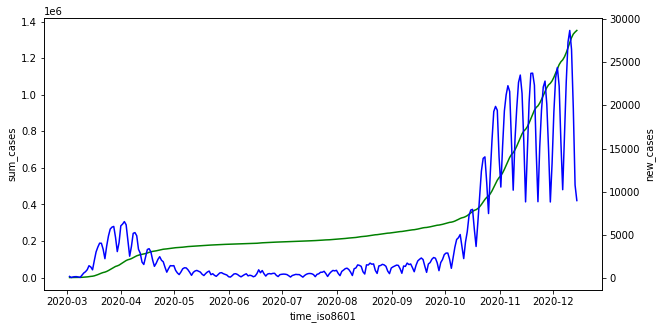

In [ ]:
all_covid.index = pd.to_datetime(all_covid.index)

covid_de = all_covid[["sum_cases"]]
covid_de["new_cases"] = all_covid["sum_cases"].diff()
covid_de.new_cases[0] = covid_de.sum_cases[0]
covid_de.new_cases =  covid_de.new_cases.astype(int)

figure = plt.figure(figsize=(10,5))
sns.lineplot(data=covid_de.sum_cases, color="g")
ax2 = plt.twinx()
sns.lineplot(data=covid_de.new_cases, color="b", ax=ax2)


Autocorrelation shows slowly decreasing correlation over time (lag, shown in x axis), also shows pattern of weekly changes in infection numbers (probably due to less case reportings at weekends), correlation peaks always at intervals of about 7 days (same weekday). Showing both autocorrelation (ignores the correlation of shorter values in between) and partial autocorrelation (corrects for the values of shorter lags in between). 

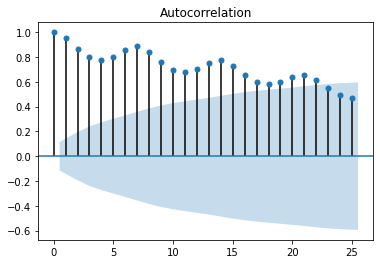

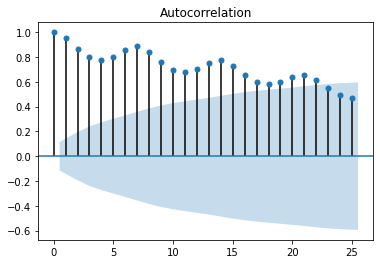

In [ ]:
plot_acf(covid_de["new_cases"])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



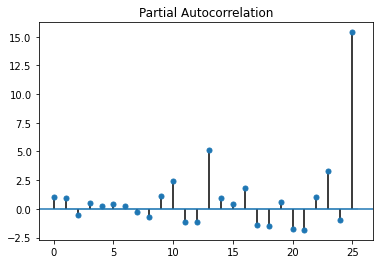

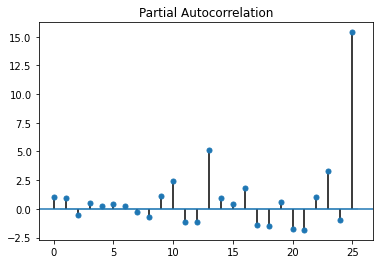

In [ ]:
plot_pacf(covid_de["new_cases"])

An autoregressive model is a model of the type $$\hat{x}_{t+K} = (x_t, x_{t-1}, ..., x_{t-M})^T\beta$$

$M$ is memory lenght, $(M+1)$ vector $\beta$ gives predictor weights

Alternatively:
$$x_t = c + \beta_1*x_{t-1} + \beta_2*x_{t-2} + ... + \beta_M*y_{t-M} + \epsilon$$

$M$ is memory limit/order, $c$ is a constant and $\epsilon$ is noise

see: 
https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401
---



---



Model: Auto regressive moving average (ARMA) (see alternative form of autoregressive model)

Estimation with Yule-Walker equation with different orders: 


Requires stationary data for "training", therefore taking log data from exponential growth since October. 



Estimation with Yule-Walker equation with different orders: 


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def predict(data, rho, sigma, no_pred):
  order = len(rho)
  for i in range(no_pred):
    last_vals = data[-order:]
    pred = int(sum(last_vals*rho))
    newdate = data.index[-1]+timedelta(days=1)
    data = data.append(pd.Series([pred], index = [newdate]))
  return data

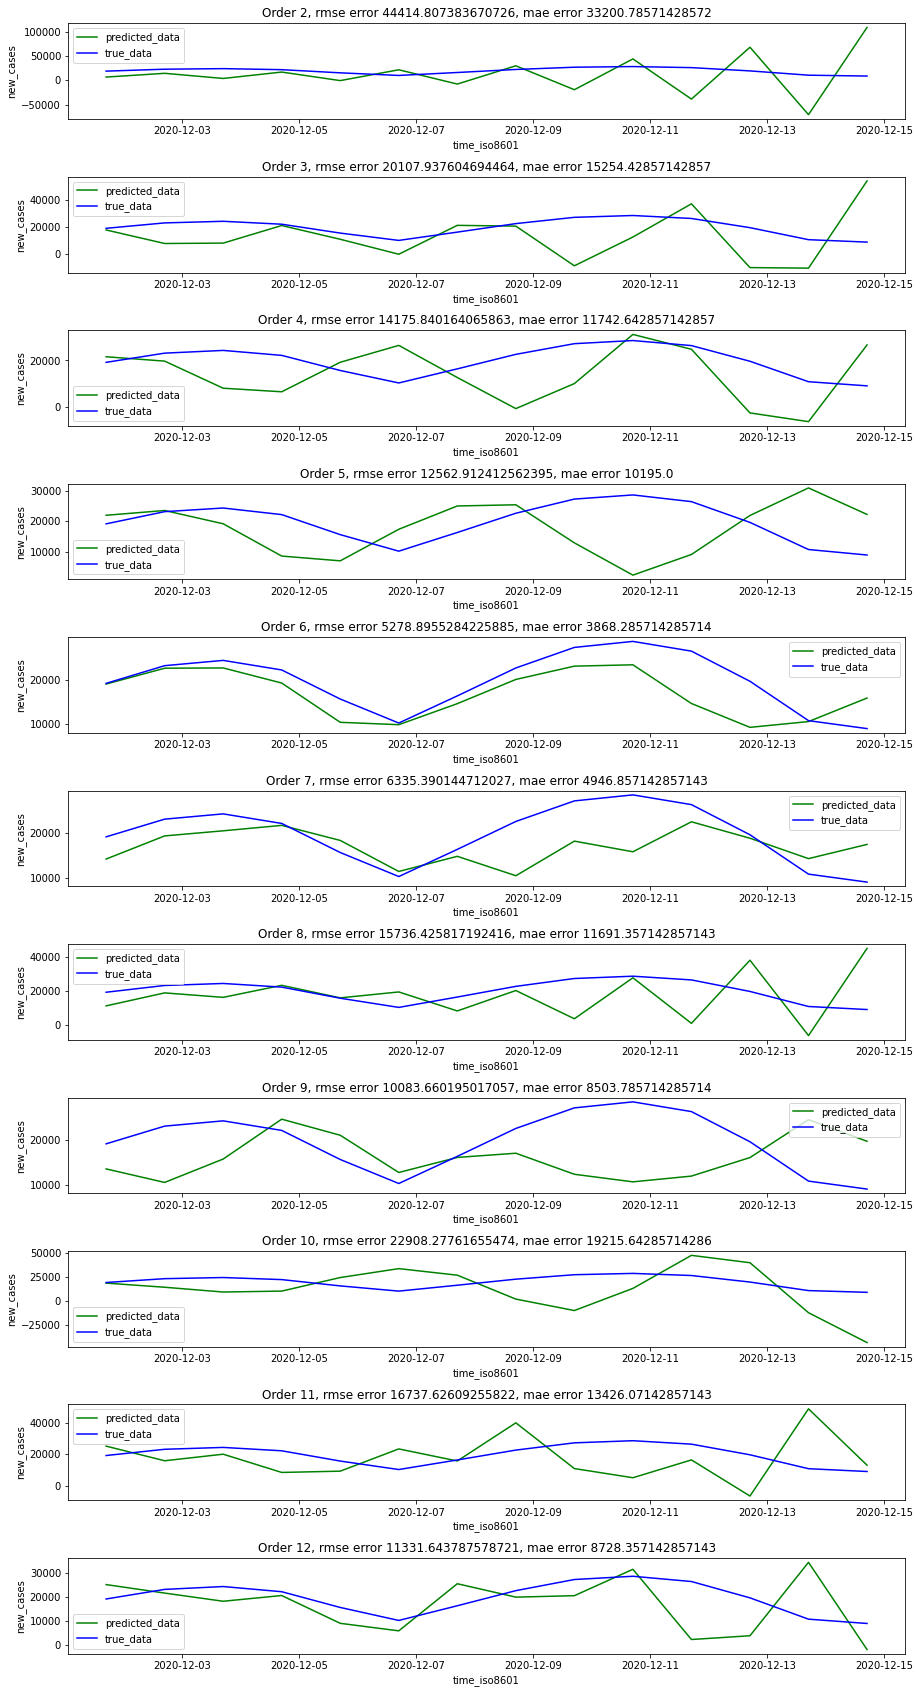

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [ ]:
orders = list(range(0, 11))

train_data = covid_de["new_cases"][0:-14]
test_data = covid_de["new_cases"][-14:]

fig, axs = plt.subplots(len(orders),1, figsize = [15,30])
plt.subplots_adjust( hspace = 0.6)

allrhos = []
allsigmas = []
errors = []
for i in orders:
  ord = i + 2
  rho, sigma = yule_walker(train_data, ord)
  sigma = float(sigma)
  allrhos.append(rho)
  allsigmas.append(sigma)
  prediction = predict(train_data, rho, sigma, 14)
  actual_pred = prediction[-14:]

  rmse = math.sqrt(mean_squared_error(actual_pred, test_data))
  mae = mean_absolute_error(actual_pred, test_data)
  errors.append(rmse)  
  figure = plt.figure(figsize=(10,5))
  sns.lineplot(data=actual_pred, color="g", ax = axs[i], label = "predicted_data")
  sns.lineplot(data=test_data, color= "b", ax = axs[i], label = "true_data")
  axs[i].title.set_text('Order {}, rmse error {}, mae error {}'.format(ord, rmse, mae))




#The Prophet
In this part of the project we used a decomposition model in order to predict future values from a time series. 

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

The Prophet uses a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

y(t)= g(t) + s(t) + h(t) + εt

g(t): piecewise linear or logistic growth curve for modeling non-periodic changes in time series

s(t): periodic changes (e.g. weekly/yearly seasonality)

h(t): effects of holidays (user provided) with irregular schedules

εt: error term accounts for any unusual changes not accommodated by the model
Using time as a regressor, Prophet is trying to fit several linear and non linear functions of time as components. Modeling seasonality as an additive component is the same approach taken by exponential smoothing in Holt-Winters technique. 
Prophet is framing the forecasting problem as a curve-fitting exercise rather than looking explicitly at the time based dependence of each observation within a time series.

Seasonal effects s(t) are approximated by the following function:
![](https://miro.medium.com/max/936/1*cnpHt71qOxrUeWkqGYDuFg.png)


## Data preparation
Prophet library has strict rules about input data. The dataset with our time series must contain two columns ds - with dates entries and y - values in this case they are the numbers of new covid cases.

In order to satisfy prophet requirements the necessary transformations were applied to the dataset. Additionally, it was split into two parts: all days but last 14 formed a training dataset and the last 14 days were used as a test one. The input data was visualized before splitting. 

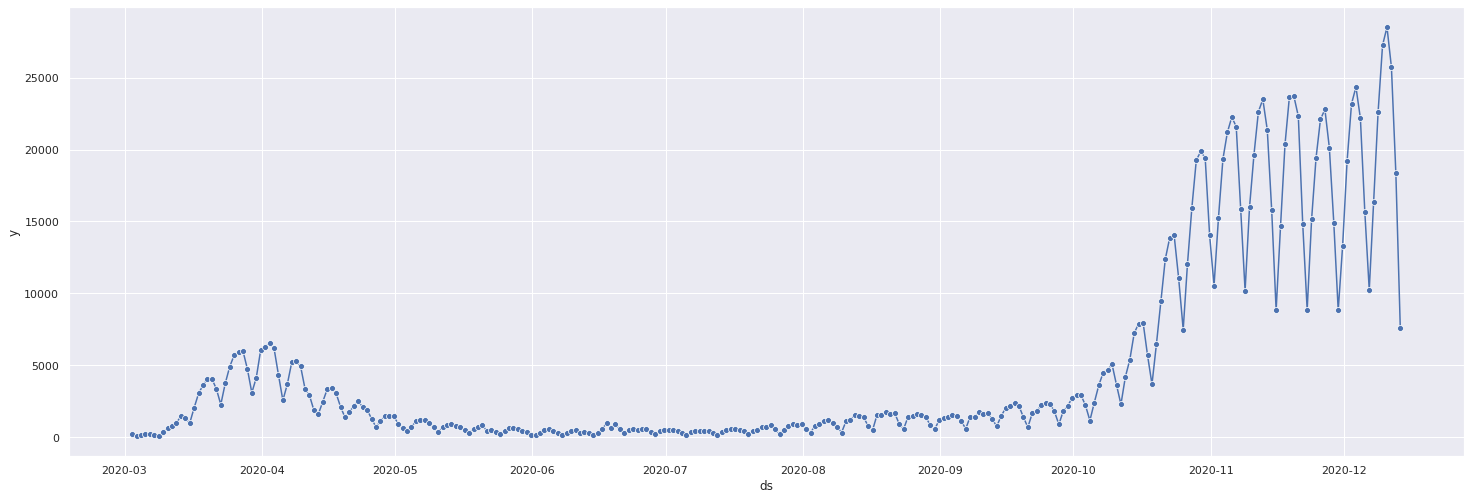

In [ ]:
def extract_time_data(df):  
  df['ds'] = pd.to_datetime(df.index)
  df['ds'] = df['ds'].dt.tz_localize(None)
  df = df.reset_index()
  df['y'] = df["sum_cases"].diff()
  result = df[['ds',"y"]]  
  return result.fillna(209)

def visualize_initial_data(df):
  sns.set(rc={'figure.figsize':(25,8.27)})
  sns.lineplot(data=df, x='ds', y='y', marker='o')
  sns.set(rc={'figure.figsize':(10,5)})

def visualize_and_prepare_data():
  df = extract_time_data(load_csv_from(data_url))
  visualize_initial_data(df)
  train = df.drop(df.index[-14:])
  y_test = df['y'][-14:].values
  return train, y_test

train, y_test = visualize_and_prepare_data()

## Prediction

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


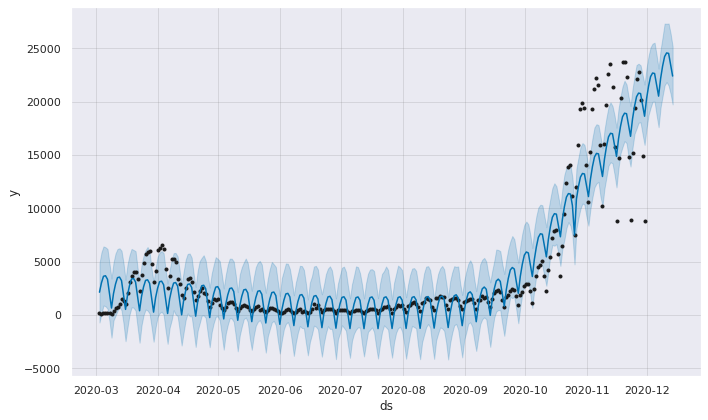

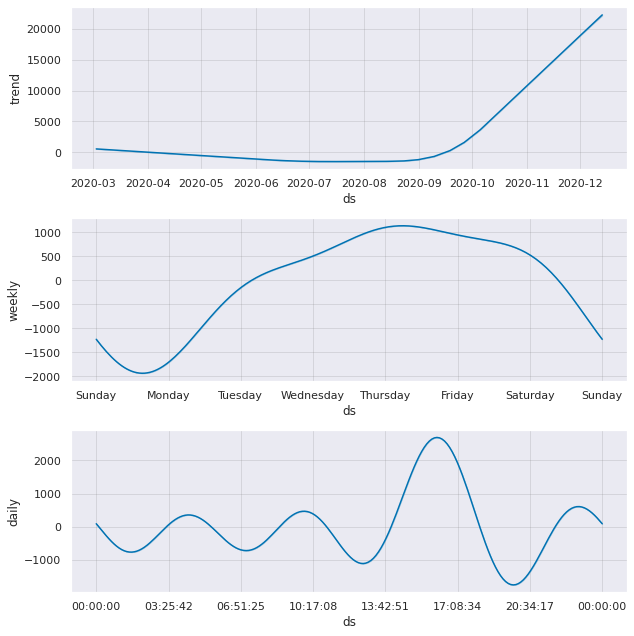

In [ ]:
def predict(train):
  m = Prophet()
  m.fit(train)
  future = m.make_future_dataframe(periods=14)
  forecast = m.predict(future)
  m.plot(forecast)
  m.plot_components(forecast)
  return forecast

forecast = predict(train)

The next step is to use prophet to make a prediction. 
The printed plot consists of: the black dots are our data points, the blue line is prophet's prediction and the light blue shade is 95% confidence interval around the forecast.

As for the forecast's components in this case Prophet determined trend, weekly, and daily components.

The trend depicts dramatic increase in new covid cases since September. The weekly seasonality corresponds to the dependency between day of a week and increment of new covid patients. The lowest point complies with Sunday and the highest one complies with Thursday. It means that on Sundays there are less detected covid cases - the value is negative. The daily component tries to determine the same increment but within one day. 

## Prediction analysis

14 14
MAE 4496.03


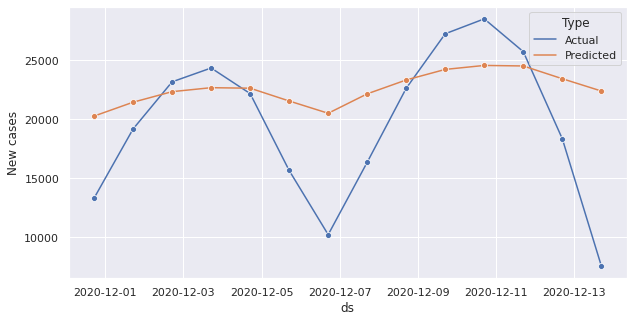

In [ ]:
def analyze_prediction(y_test, forecast):  
  y_pred = forecast['yhat'].values[-14:]  
  dates = forecast['ds'].values[-14:]
  types = ['Actual'] * len(y_test) + ['Predicted'] * len(y_test)
  data = pd.DataFrame({'New cases': np.concatenate([y_test, y_pred]), 'Type': types, 'ds': np.concatenate([dates, dates])})
  sns.lineplot(data=data, hue='Type', x='ds', y='New cases', marker='o')
  print(len(y_pred), len(y_test))
  print('MAE', round(mean_absolute_error(y_test, y_pred), 2))

analyze_prediction(y_test, forecast)

Unfortunately, untuned model underestimates the weight of weekends and therefore we get a huge mismatch between real and forecasted values around weekends. The calculated mean absolute error is about 4496.

## Change points
Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible.

We used two parameters to adjust change point detection because default settings didn't provide good results. These parameters are nubmer of change points and changepoint prior scale - parameter modulating the flexibility of the automatic changepoint selection.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


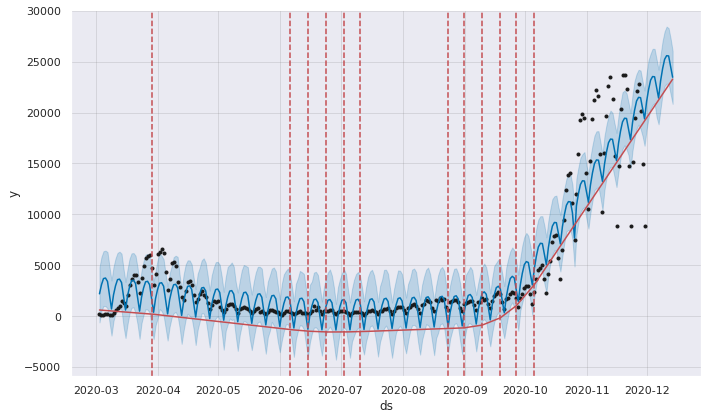

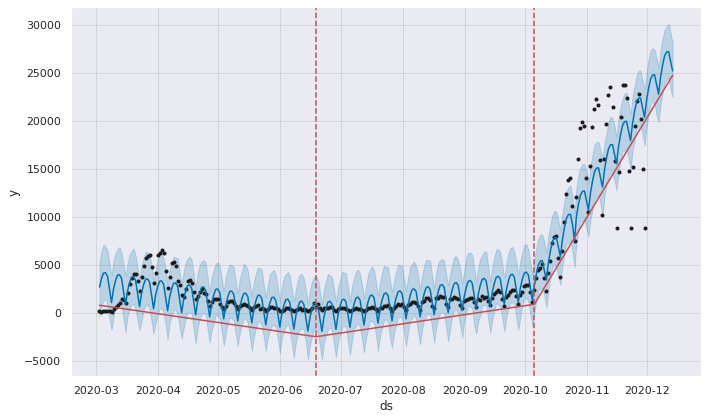

In [ ]:
def detect_change_points(train, changepoint_prior_scale, n_changepoints=25):
  m = Prophet(changepoint_prior_scale=changepoint_prior_scale, n_changepoints=n_changepoints)
  m.fit(train)
  future = m.make_future_dataframe(periods=14)
  forecast = m.predict(future)
  fig = m.plot(forecast)
  a = add_changepoints_to_plot(fig.gca(), m, forecast)

detect_change_points(train, 0.08)
detect_change_points(train, 0.1, 2)

As we can see from the resulting plots Prophet detected change points connected to decrease of covid cases at the end of the first wave, minor increase in the summer, and steep growth after September.